cleaner notebook

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [ ]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [1]:
from time import time, sleep
import random
import urllib
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import bs4
from bs4 import BeautifulSoup
import re
from IPython.display import clear_output

In [ ]:
#captcha alert settings
import winsound
duration = 5000  # milliseconds
freq = 440  # Hz

In [ ]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

In [ ]:
print(soup.prettify())

OK, we successfully downloaded the page, let's take a good look at the content

In [ ]:
print(soup.get_text())

Good, not blocked by captcha but the content is hard to read. The content that we want could be obtained with the html tags.

In [ ]:
card=[]
for a in soup.find_all("div", class_='job_seen_beacon'): #html tag for the 'cards'
    card.append(a.get_text())
card

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [ ]:
def parse(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
    df = pd.DataFrame(columns=["Title","Location","Company","Salary", "Synopsis"])
    for each in soup.find_all(class_= "result" ):
        try: 
            title = each.find(class_='jobTitle').text.replace('\n', '').replace('new', '')
        except:
            title = 'None'
        try:
            location = each.find('div', {'class':"companyLocation" }).text.replace('\n', '')
        except:
            location = 'None'
        try: 
            company = each.find(class_='companyName').text.replace('\n', '')
        except:
            company = 'None'
        try:
            salary = each.find('div', {'class': "metadata salary-snippet-container"}).text.replace('\n', '')
        except:
            try:
                salary = each.find('span', {'class':'estimated-salary'}).text.replace('\n', '')
            except:
                salary = 'None'
        synopsis = each.find('div', {'class':'job-snippet'}).text.replace('\n', '')
        df = df.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary, 'Synopsis':synopsis}, ignore_index=True)
    return df

In [ ]:
parse(URL)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [ ]:
#headers to mask browsing data with python
headers_list = [
# Firefox 77 Mac
{
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0",
"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
"Accept-Language": "en-US,en;q=0.5",
"Referer": "https://www.google.com/",
"DNT": "1",
"Connection": "keep-alive",
"Upgrade-Insecure-Requests": "1"
},
# Firefox 77 Windows
{
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0",
"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
"Accept-Language": "en-US,en;q=0.5",
"Accept-Encoding": "gzip, deflate, br",
"Referer": "https://www.google.com/",
"DNT": "1",
"Connection": "keep-alive",
"Upgrade-Insecure-Requests": "1"
},
# Chrome 83 Mac
{
"Connection": "keep-alive",
"DNT": "1",
"Upgrade-Insecure-Requests": "1",
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
"Sec-Fetch-Site": "none",
"Sec-Fetch-Mode": "navigate",
"Sec-Fetch-Dest": "document",
"Referer": "https://www.google.com/",
"Accept-Encoding": "gzip, deflate, br",
"Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8"
},
# Chrome 83 Windows 
{
"Connection": "keep-alive",
"Upgrade-Insecure-Requests": "1",
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
"Sec-Fetch-Site": "same-origin",
"Sec-Fetch-Mode": "navigate",
"Sec-Fetch-User": "?1",
"Sec-Fetch-Dest": "document",
"Referer": "https://www.google.com/",
"Accept-Encoding": "gzip, deflate, br",
"Accept-Language": "en-US,en;q=0.9"
}
]

In [ ]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 5000
cities = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
          'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
          'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Boston',
          'Charlottesville', 'Richmond', 'Baltimore', 'Harrisonburg', 'San+Antonio', 'San+Diego', 'San+Jose',
          'Austin', 'Jacksonville', 'Indianapolis', 'Columbus', 'Fort+Worth', 'Charlotte', 'Detroit', 'El+Paso', 
          'Memphis', 'Orlando', 'Nashville', 'Louisville', 'Milwaukee', 'Las+Vegas', 'Albuquerque', 'Tucson', 
          'Fresno', 'Sacramento', 'Long+Beach', 'Mesa', 'Virginia+Beach', 'Norfolk', 'Atlanta', 'Colorado+Springs',
          'Raleigh', 'Omaha', 'Oakland', 'Tulsa', 'Minneapolis', 'Cleveland', 'Wichita', 'Arlington', 'New+Orleans', 
          'Bakersfield', 'Tampa', 'Honolulu', 'Anaheim', 'Aurora', 'Santa+Ana', 'Riverside', 'Corpus+Christi', 
          'Pittsburgh', 'Lexington', 'Anchorage', 'Cincinnati', 'Baton+Rouge', 'Chesapeake', 'Alexandria', 'Fairfax', 
          'Herndon','Reston', 'Roanoke', 'Boulder', 'Pasadena', 'Greensboro', 'Newark', 'Kansas+City', 'Abilene',
          "Baton Rouge", 'Bridgeport', 'Lubbock', 'Amarillo', 'Oklahoma+City', 'Clinton', 'Stillwater', 'Berkeley',
          'Palo+Alto', 'Cupertino', 'Buffalo', 'Dayton', 'Washington+DC', 'Huntsville']

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [ ]:
i = 0
count = 0
results = []

for city in set(cities):
    for start in range(0, max_results_per_city, 10):
        # create new csv file for city or open if already exist
        # each city has its own dataframe saved in individual csv
        file = 'data_by_cities/'+str(city)+'.csv'
        try: 
            df_more = pd.read_csv(file , sep='\t', encoding='utf-8', index_col=0)
            print('file successfully opened')
        except:
            print('file not found, creating new file')
            df_more = pd.DataFrame(columns=["Title","Location","Company","Salary", "Synopsis"])
            df_more.to_csv(file, sep='\t', encoding='utf-8')
        datasize = df_more.shape #keep track of size of exisiting dataframe
        url = url_template.format(city, start)
        headers = random.choice(headers_list)
        r = requests.Session()
        r.headers = headers
        html = r.get(url)
        soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
        #captcha detector
        if 'hCaptcha solve page' in soup.get_text():
            print('captcha detected')
            winsound.Beep(freq, duration) #sound alert, might get irritating, probably won't work on mac
            input("Press Enter to continue...")#this would pause the code until i press enter
        for each in soup.find_all(class_= "result" ):
            try: 
                title = each.find(class_='jobTitle').text.replace('\n', '').replace('new', '')
            except:
                title = 'None'
            try:
                location = each.find('div', {'class':"companyLocation" }).text.replace('\n', '')
            except:
                location = 'None'
            try: 
                company = each.find(class_='companyName').text.replace('\n', '')
            except:
                company = 'None'
            try:
                salary = each.find('div', {'class': "metadata salary-snippet-container"}).text.replace('\n', '')
            except:
                try:
                    salary = each.find('span', {'class':'estimated-salary'}).text.replace('\n', '')
                except:
                    salary = 'None'
            synopsis = each.find('div', {'class':'job-snippet'}).text.replace('\n', '')
            df_more = df_more.append({'Title':title, 'Location':location, 'Company':company, 'Salary':salary, 'Synopsis':synopsis}, ignore_index=True)
            #drop duplicates
            df_more = df_more[~df_more.duplicated()].reset_index(drop=True)
        #count the number of pages scraped and print, so I know how far the code is running
        count+= 1
        print(count, ' loops done, proceed to sleep, current city is ', city)
        if df_more.shape == datasize: #move to next city if we don't get new data. it's pointless to continue without getting new data.
            print(df_more.shape,' no new data, moving to next city')
            break       
        df_more.to_csv(file, sep='\t', encoding='utf-8') #write every scraped page so i don't lose my data again
        sleep(random.randint(7,20)) #pause to mimic human
        clear_output(wait=True) #I don't want too see long line of the process, clear_output will clear previous lines
        print(df_more.shape, ' data saved, last visited city is ', city, ', continuing....')
    print('moving to next city')
    sleep(random.randint(10,30)) #longer pause before moving to new city to mimic human

In [26]:
import glob
combined_csv = pd.DataFrame()
for f in glob.glob(".\data_by_cities/*.csv"):

    df = pd.read_csv(f, sep='\t', encoding='utf-8', index_col=0) # make sure to apply correct settings (sep, parse_dates, headers, missing_values)
    df["origin"] = f.replace(".\data_by_cities\\","").replace(".csv","") #add a column with a csv name
    combined_csv = df_all.append(df) #append new df to the "master" dataframe

combined_csv.to_csv("merged.csv")
combined_csv

,Title,Location,Company,Salary,Synopsis,origin
0,Senior Data Scientist - Delivery Insights,Remote in Texas,Indeed,"$139,000 - $201,000 a year",Passion to answer Product/Engineering question...,Abilene
1,Senior Data Analyst,Remote in Texas,Hire With Jarvis,"$120,000 - $170,000 a year",Expertise in SQL and data visualization.Experi...,Abilene
2,Data Scientist - (2+ yrs of statistics & R pro...,Texas,#twiceasnice Recruiting,Estimated $96.7K - $122K a year,Salary: Commensurate with Experience + Bonus +...,Abilene
3,Data Scientist - Entry to Expert Level Virtual...,United States,National Security Agency (NSA),"$74,682 - $176,300 a year",Passing this examination is a requirement in o...,Abilene
4,"Director, Data Science- SMB Labs",Remote in United States,Indeed,"$214,000 - $310,000 a year","In this role, you will lead teams of machine l...",Abilene
...,...,...,...,...,...,...
23,Senior Data Scientist/Machine Learning Engineer,"Remote in Wichita, KS 67212+5 locations",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita
24,Data Plane Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita
25,NLP Engineer at Speech to Text Start Up,"Remote in Wichita, KS 67212",Recruiting From Scratch,Estimated $115K - $145K a year,Who is Recruiting from Scratch: Recruiting fro...,Wichita
26,Principal ML & NLP Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita


Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [27]:
#drop duplicates
combined_csv = combined_csv[~combined_csv.duplicated()].reset_index(drop=True)
combined_csv

,Title,Location,Company,Salary,Synopsis,origin
0,Senior Data Scientist - Delivery Insights,Remote in Texas,Indeed,"$139,000 - $201,000 a year",Passion to answer Product/Engineering question...,Abilene
1,Senior Data Analyst,Remote in Texas,Hire With Jarvis,"$120,000 - $170,000 a year",Expertise in SQL and data visualization.Experi...,Abilene
2,Data Scientist - (2+ yrs of statistics & R pro...,Texas,#twiceasnice Recruiting,Estimated $96.7K - $122K a year,Salary: Commensurate with Experience + Bonus +...,Abilene
3,Data Scientist - Entry to Expert Level Virtual...,United States,National Security Agency (NSA),"$74,682 - $176,300 a year",Passing this examination is a requirement in o...,Abilene
4,"Director, Data Science- SMB Labs",Remote in United States,Indeed,"$214,000 - $310,000 a year","In this role, you will lead teams of machine l...",Abilene
...,...,...,...,...,...,...
19292,Senior Data Scientist/Machine Learning Engineer,"Remote in Wichita, KS 67212+5 locations",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita
19293,Data Plane Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita
19294,NLP Engineer at Speech to Text Start Up,"Remote in Wichita, KS 67212",Recruiting From Scratch,Estimated $115K - $145K a year,Who is Recruiting from Scratch: Recruiting fro...,Wichita
19295,Principal ML & NLP Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita


In [28]:
#drop estimates
rslt_df = combined_csv[combined_csv['Salary'] != 'None']
estimated = rslt_df.loc[rslt_df['Salary'].str.contains("Estimated")].index
rslt_df.drop(estimated, inplace=True)
rslt_df.reset_index(drop=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
#check for salaries that are not yearly
yearly = rslt_df.loc[rslt_df['Salary'].str.contains("year")].index
yearly

Int64Index([   0,    1,    2,    3,    4,    5,    7,    9,   10,   11,
            ...
            4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310],
           dtype='int64', length=3774)

In [30]:
hourly = rslt_df.loc[rslt_df['Salary'].str.contains("hour")].index
hourly

Int64Index([   6,   18,   35,   44,   49,   79,  108,  117,  120,  122,
            ...
            4154, 4165, 4173, 4175, 4248, 4252, 4253, 4257, 4270, 4298],
           dtype='int64', length=464)

In [31]:
monthly = rslt_df.loc[rslt_df['Salary'].str.contains("month")].index
monthly

Int64Index([  12,   14,   34,   47,   72,  130,  262,  302,  304,  399,  582,
             585,  597,  599,  606,  610,  612,  639,  645,  651,  653,  655,
             691,  694,  740,  979, 1442, 1457, 1475, 1500, 1654, 1949, 1980,
            2010, 2065, 2207, 2240, 2301, 2342, 2356, 2357, 2374, 2380, 2485,
            2546, 2598, 2611, 2649, 3171, 3176, 3225, 3246, 3264, 3281, 3293,
            3328, 3357, 3477, 3492, 3522, 3720, 3721, 3999, 4262, 4272],
           dtype='int64')

In [32]:
daily = rslt_df.loc[rslt_df['Salary'].str.contains("day")].index
daily

Int64Index([352, 360, 1627], dtype='int64')

In [33]:
weekly = rslt_df.loc[rslt_df['Salary'].str.contains("week")].index
weekly

Int64Index([8, 20, 1951, 2932, 3732], dtype='int64')

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [34]:
#It is much easier and tidier to code both processing steps in one block of code.
# we convert salary to annual salary using the formula:
# Hourly: Multiply by 2,000
# Daily: Multiply by 200
# Weekly: Multiply by 50
# Monthly: Multiply by 12
# I don't know the actual number so this is very rough estimate.
# for other annual salary given in range: convert to mean value

In [35]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [36]:
# function to convert salary col
def process_salary(sal):
    sal = str(sal)
    sal = sal.replace("$","").replace(",","").replace("-"," ")
    value = np.mean([float(s) for s in sal.split() if s.isdecimal() or isfloat(s)])
    if "year" in sal:
        newsal = value
    elif "month" in sal: 
        newsal = value*12
    elif "week" in sal: 
        newsal = value*50
    elif "day" in sal: 
        newsal = value*200
    elif "hour" in sal: 
        newsal = value*2000
    else:
        newsal = sal
    return newsal

In [37]:
rslt_df['mean_annual_salary'] = rslt_df['Salary'].map(lambda x: process_salary(x))

C:\Users\fullb\AppData\Local\Temp/ipykernel_25236/2696525605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rslt_df['mean_annual_salary'] = rslt_df['Salary'].map(lambda x: process_salary(x))


In [38]:
rslt_df

,Title,Location,Company,Salary,Synopsis,origin,mean_annual_salary
0,Senior Data Scientist - Delivery Insights,Remote in Texas,Indeed,"$139,000 - $201,000 a year",Passion to answer Product/Engineering question...,Abilene,170000.0
1,Senior Data Analyst,Remote in Texas,Hire With Jarvis,"$120,000 - $170,000 a year",Expertise in SQL and data visualization.Experi...,Abilene,145000.0
2,Data Scientist - Entry to Expert Level Virtual...,United States,National Security Agency (NSA),"$74,682 - $176,300 a year",Passing this examination is a requirement in o...,Abilene,125491.0
3,"Director, Data Science- SMB Labs",Remote in United States,Indeed,"$214,000 - $310,000 a year","In this role, you will lead teams of machine l...",Abilene,262000.0
4,Data Science Manager - Search Ranking and Pers...,Remote in United States,Indeed,"$149,000 - $217,000 a year","Ensure delivery of data science solutions, set...",Abilene,183000.0
...,...,...,...,...,...,...,...
4306,Senior Data Scientist at Rent-to-Own Startup,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$120,000 - $190,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,155000.0
4307,Senior Data Scientist/Machine Learning Engineer,"Remote in Wichita, KS 67212+5 locations",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,170000.0
4308,Data Plane Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,170000.0
4309,Principal ML & NLP Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,170000.0


In [39]:
rslt_df.dtypes

Title                  object
Location               object
Company                object
Salary                 object
Synopsis               object
origin                 object
mean_annual_salary    float64
dtype: object

### Save your results as a CSV

In [40]:
#save data as new csv
rslt_df
rslt_df.to_csv('cleaned_data.csv', sep='\t', encoding='utf-8')

### Load in the the data of scraped salaries

In [41]:
df_clean = pd.read_csv('cleaned_data.csv' , sep='\t', encoding='utf-8', index_col=0)

In [42]:
df_clean

,Title,Location,Company,Salary,Synopsis,origin,mean_annual_salary
0,Senior Data Scientist - Delivery Insights,Remote in Texas,Indeed,"$139,000 - $201,000 a year",Passion to answer Product/Engineering question...,Abilene,170000.0
1,Senior Data Analyst,Remote in Texas,Hire With Jarvis,"$120,000 - $170,000 a year",Expertise in SQL and data visualization.Experi...,Abilene,145000.0
2,Data Scientist - Entry to Expert Level Virtual...,United States,National Security Agency (NSA),"$74,682 - $176,300 a year",Passing this examination is a requirement in o...,Abilene,125491.0
3,"Director, Data Science- SMB Labs",Remote in United States,Indeed,"$214,000 - $310,000 a year","In this role, you will lead teams of machine l...",Abilene,262000.0
4,Data Science Manager - Search Ranking and Pers...,Remote in United States,Indeed,"$149,000 - $217,000 a year","Ensure delivery of data science solutions, set...",Abilene,183000.0
...,...,...,...,...,...,...,...
4306,Senior Data Scientist at Rent-to-Own Startup,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$120,000 - $190,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,155000.0
4307,Senior Data Scientist/Machine Learning Engineer,"Remote in Wichita, KS 67212+5 locations",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,170000.0
4308,Data Plane Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,170000.0
4309,Principal ML & NLP Engineer,"Remote in Wichita, KS 67212",Recruiting From Scratch,"$140,000 - $200,000 a year",Who is Recruiting from Scratch: Recruiting fro...,Wichita,170000.0


### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [43]:
df_clean.describe()

,mean_annual_salary
count,4311.000000
mean,133367.819763
std,47601.704533
min,16000.000000
25%,101313.000000
50%,130000.000000
75%,160000.000000
max,310000.000000


The mean and 50 percentile (which is the median) are pretty close, our data don't have many outliers. It's better to look at the distribution before deciding the cut off.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


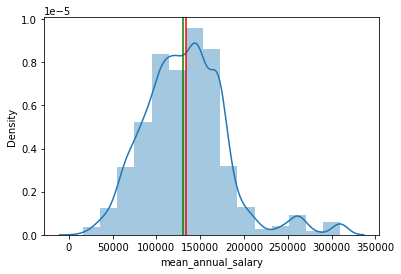

In [44]:
import seaborn as sns
ax = sns.distplot(df_clean['mean_annual_salary'], bins=15)
ax.axvline(df_clean['mean_annual_salary'].mean(), c='r')
ax.axvline(df_clean['mean_annual_salary'].median(), c='g')

Our data is not normally distributed but the mean and median are extremely close, the data set has a symmetrical distribution.

In [45]:
median_salary = np.median(df_clean.mean_annual_salary)
median_salary

130000.0

In [46]:
df_clean['salary_class'] = [1 if i > median_salary else 0 for i in df_clean.mean_annual_salary]

In [47]:
df_clean.salary_class.value_counts()

0    2157
1    2154
Name: salary_class, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

In [ ]:
1214/2404

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [ ]:
## YOUR CODE HERE

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [ ]:
## YOUR CODE HERE

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 